# Classification des documents du procès des groupes américains du tabac

Réalisé par: Nasreddine Menacer<br>
Université de Rouen / Master 2 SD-2018/2019

# Contexte

# 1- Analyse des données

Le gouvernement américain a attaqué en justice cinq grands groupes américains du tabac pour avoir amassé d'importants bénéfices en mentant sur les dangers de la cigarette. Le cigarettiers  se sont entendus dès 1953, pour "mener ensemble une vaste campagne de relations publiques afin de contrer les preuves de plus en plus manifestes d'un lien entre la consommation de tabac et des maladies graves".
Dans ce procès 14 millions de documents ont été collectés et numérisés. Afin de faciliter l'exploitation de ces documents par les avocats, vous êtes en charge de mettre en place une classification automatique des types de documents.
Un échantillon aléatoire des documents a été collecté et des opérateurs ont classé les documents dans des répertoires correspondant aux classes de documents : lettres, rapports, notes, email, etc.

Chargement des Packages 

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

- Premièrement je vais charger le fichier 'Tobacco3482.csv' qui contient la classe de  chaque document,
définies par des opérateurs.

In [3]:
data= pd.read_csv('Tobacco3482.csv')

- Je vais ensuite faire une analyse statistique des données

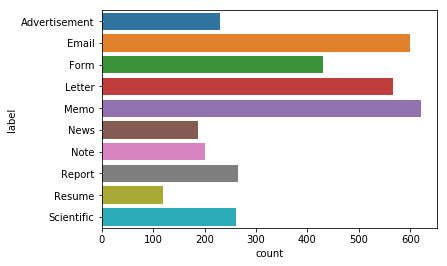

In [4]:
sns.countplot(data=data,y='label') 
plt.show()

On constate que pour des techniques de classification et de traitement automatique de texte, le nombre des données est faible, et qu'il y a seulement quatre étiquettes plus présentes que les autres

- J'ai aussi effectué une analyse descriptive qui va permettre d'étudier la distribution des classes

In [5]:
classes = pd.read_csv('Tobacco3482.csv', sep = ",")
classes.sample(10)

,img_path,label
2467,News/1002402255-a.jpg,News
628,Email/2085725088c.jpg,Email
471,Email/2081499563a.jpg,Email
2607,News/2083781257.jpg,News
1101,Form/2083849128.jpg,Form
786,Email/528954681+-4681.jpg,Email
2408,Memo/96018853_8858.jpg,Memo
3319,Scientific/2057342922_2947.jpg,Scientific
3206,Resume/50638712-8712.jpg,Resume
2727,Note/2030053173.jpg,Note


- J'ai aussi vérifier s'il y a des étiquettes manquantes, des incohérence entre la classe réelle du document et la classe notée 

In [6]:
print("Les étiquettes manquantes :", 1.0 - classes.shape[0] / classes.dropna().shape[0])
s = 0
for i in range(classes.shape[0]):
    s += classes["img_path"][i].split("/")[0] == classes["label"][i]
print("Les documents mal classé :", classes.shape[0] - s)

Les étiquettes manquantes : 0.0
Les documents mal classé : 0


On a la certitude qu'il n'y a aucun document mal classé, et qu'il n'y a aucune étiquette manquantes

- Pour avoir une idée des données qu'on vas manipuler j'ai visualisé un echentillont du fichier

In [7]:
data_txt=[]
data_txt=data

NB = data_txt.shape[0]
for i in range (NB):
    A = data_txt.get_value(i, 'img_path')
    data_txt.set_value(i, 'img_path', 'Tobacco3482-OCR/'+A)
    data_txt.set_value(i, 'img_path', data_txt.get_value(i, 'img_path').split('.jpg')[0]+'.txt')
    data_txt.set_value(i, 'img_path',open(data_txt.get_value(i, 'img_path'), "r",encoding="utf8").read())
data_txt.columns = ['text','label']
print(data_txt.head())

                                                text          label
0  A Mpertant as yar\nsesiye teaetered cabiieess....  Advertisement
1  TE che fitm\n\nm66400 7127\n\nKOOLS are the on...  Advertisement
2  so ARN Rr nr\n\nBWR Ga ||\n\nVending Operators...  Advertisement
3  MARCH 24,19 VO — 3. Tersrearep\n\n \n\n‘ yi il...  Advertisement
4  ~\n\nSpend a milder moment qs\nwith Raleigh.\n...  Advertisement


On peut visualiser ici les quatre premiers textes (une partie du texte), et l'étiquette associée a celui-ci

# 2-Machine learniing

j'ai choisie ici d'appliquer deux mèthodes de machine learning, et donc traiter le texte, pour essayer d'entrainer les classifieurs et essayer de prédire la classe d'un document.

### 2.1-Bag of Word

Pour appliquer la méthode de bag of word, les documents doivent être transformés en vecteurs. Pour cela j'ai transformer les documents en vecteurs et je les est encodés en sac de mots en utilisant la fonction CountVectorizer de Sklearn.

Avant ça j'ai dévisé les données en trois parties, données d'entrainement, données de test, et données de validation.

In [8]:
X_train, X_app, y_train, y_app = train_test_split(data['text'], data['label'], test_size=0.4)
X_test,X_dev,y_test,y_dev=train_test_split(X_app, y_app, test_size=0.5)

j'ai pris 60% des données comme données d'entrainement, et les 40% qui reste sont dévisés en deux pour servir de données de teste et de validation 

In [9]:
print('train data size=',X_train.shape[0],'X_test data size=',X_test.shape[0],'dev data size=',X_dev.shape[0])

train data size= 2089 X_test data size= 696 dev data size= 697


In [10]:
vectorizer = CountVectorizer(max_features=2000)
vectorizer.fit(X_train)
X_train_counts = vectorizer.transform(X_train)
X_dev_counts = vectorizer.transform(X_dev)
X_test_counts = vectorizer.transform(X_test)    

- J'ai ensuite appliqué la fonction GridSearsh sur un classifieur bayésien naïf, pour trouver le meilleur paramètre alpha, avec une cross validation=5, la précision du classifieur est la moyenne des précision de chaque opération.
- Le principe de ce classifieur est d'utiliser une hypothèse d'indépendence entre les caractéristiques des classes pour estimer une probabilité associée à l'appartenance à une classe.

In [11]:
parameters = {'alpha' : [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 7.0, 8.0, 9.0, 10.0]}

nb_classifier = MultinomialNB()
grid_search_clf = GridSearchCV(nb_classifier, parameters, cv=5, return_train_score=True)
grid_search_clf.fit(X_train_counts, y_train)
res = grid_search_clf.cv_results_

for i in range(1,11):
    print('Rang', i)
    ind = np.where(res['rank_test_score'] == i)
    print('Alpha : {}'.format(res['params'][ind[0][0]]['alpha']))
    print('La précision moyenne : {}\n'.format(round(res['mean_test_score'][ind][0], 3)))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\naive_bayes.py:472: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


Rang 1
Alpha : 1.0
La précision moyenne : 0.722

Rang 2
Alpha : 2.0
La précision moyenne : 0.717

Rang 3
Alpha : 3.0
La précision moyenne : 0.711

Rang 4
Alpha : 4.0
La précision moyenne : 0.707

Rang 5
Alpha : 5.0
La précision moyenne : 0.703

Rang 6
Alpha : 7.0
La précision moyenne : 0.683

Rang 7
Alpha : 8.0
La précision moyenne : 0.677

Rang 8
Alpha : 9.0
La précision moyenne : 0.673

Rang 9
Alpha : 10.0
La précision moyenne : 0.67

Rang 10
Alpha : 0.0
La précision moyenne : 0.644



Aprés dix valuers de alpha testés par GridSearch, on remparque que la valeur 1 donne la meilleur precision, je vais utiliser cette valeur donc pour construire un classifiur bayésien, l'entrainé et le testé sur les données de teste et de validation.

In [12]:
nb_classifier = MultinomialNB(alpha=1.)
nb_classifier.fit(X_train_counts, y_train)

pred_train = nb_classifier.predict(X_train_counts)
pred_dev = nb_classifier.predict(X_dev_counts)
pred_test = nb_classifier.predict(X_test_counts)

print("La précision sur les données d'entrainement est : ", metrics.accuracy_score(y_train, pred_train))
print("La précision sur les données de validation est : ", metrics.accuracy_score(y_dev, pred_dev))
print("La précision sur les données de test est : ", metrics.accuracy_score(y_test, pred_test))

La précision sur les données d'entrainement est :  0.8276687410244136
La précision sur les données de validation est :  0.7187948350071736
La précision sur les données de test est :  0.7083333333333334


### 2.2-TF IDF

In [13]:
tf_transformer = TfidfTransformer().fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
X_dev_tf = tf_transformer.transform(X_dev_counts)
X_test_tf = tf_transformer.transform(X_test_counts)

De meme que pour la methode de bag of word, je vais utiliser, le classifieur bayésien, créé avec un alpha=1, pour calculer la precision sur chaque jeux de données.

In [14]:
nb_classifier.fit(X_train_tf, y_train)

pred_train_tf = nb_classifier.predict(X_train_tf)
pred_dev_tf = nb_classifier.predict(X_dev_tf)
pred_test_tf = nb_classifier.predict(X_test_tf)

print("La précision sur les données d'entrainement est: ", metrics.accuracy_score(y_train, pred_train_tf))
print("La précision sur les données de validation est : ", metrics.accuracy_score(y_dev, pred_dev_tf))
print("La précision sur les données de test est : ", metrics.accuracy_score(y_test, pred_test_tf))

La précision sur les données d'entrainement est:  0.7510770703685974
La précision sur les données de validation est :  0.648493543758967
La précision sur les données de test est :  0.6609195402298851


# 3-Deep Learning

### - MLP with BoW

J'ai choisie dans cette partie d'implémenter un MLP ( multi layer perceptrant), en utilisant un GridSearch  et  les données issus de la methode bag of word, puisque c'est elle qui nous à donné de meilleur résultat de pecision, le GridSearch avec une cross validation vas nous donner les meilleur paramètres à utiliser dans notre modèle, avec 10 itération j'ai choisie entre 1 et 5 neurone dans la couche, pour la couche d'activation entre 'tanh' et 'relu', et entre 'adam' et 'sgd' pour le solveur.

In [25]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=10)

parameter_space = {
    'hidden_layer_sizes': [(i,) for i in range(1,5)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [1,5],
    'learning_rate': ['constant','adaptive'],
}

from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train_counts, y_train)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\neural_network\multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


GridSearchCV(cv=3, error_score='raise',
       estimator=MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=10, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'hidden_layer_sizes': [(1,), (2,), (3,), (4,)], 'activation': ['tanh', 'relu'], 'solver': ['sgd', 'adam'], 'alpha': [1, 5], 'learning_rate': ['constant', 'adaptive']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

ici les meilleur paramatères sont affichés 

In [26]:
print('Best parameters found:\n', clf.best_params_)

means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found:
 {'activation': 'tanh', 'alpha': 1, 'hidden_layer_sizes': (4,), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.066 (+/-0.049) for {'activation': 'tanh', 'alpha': 1, 'hidden_layer_sizes': (1,), 'learning_rate': 'constant', 'solver': 'sgd'}
0.216 (+/-0.181) for {'activation': 'tanh', 'alpha': 1, 'hidden_layer_sizes': (1,), 'learning_rate': 'constant', 'solver': 'adam'}
0.137 (+/-0.065) for {'activation': 'tanh', 'alpha': 1, 'hidden_layer_sizes': (1,), 'learning_rate': 'adaptive', 'solver': 'sgd'}
0.256 (+/-0.023) for {'activation': 'tanh', 'alpha': 1, 'hidden_layer_sizes': (1,), 'learning_rate': 'adaptive', 'solver': 'adam'}
0.177 (+/-0.127) for {'activation': 'tanh', 'alpha': 1, 'hidden_layer_sizes': (2,), 'learning_rate': 'constant', 'solver': 'sgd'}
0.286 (+/-0.250) for {'activation': 'tanh', 'alpha': 1, 'hidden_layer_sizes': (2,), 'learning_rate': 'constant', 'solver': 'adam'}
0.159 (+/-0.066) for {'activation': 'tanh', 'alpha': 1, 'hidden_layer_sizes': (2,),

je vais utiliser ensuite ces paramètres pour essayer de prédir la classe de chaque documents des données de test 

In [27]:
y_true, y_pred = y_test , clf.predict(X_test_counts)

# 3-Analyse des Performances 

In [16]:
print('Naive Bayse Bag Of  Word  \n')
print("La précision sur les données d'entrainement est : ", metrics.accuracy_score(y_train, pred_train))
print("La précision sur les données de validation est : ", metrics.accuracy_score(y_dev, pred_dev))
print("La précision sur les données de test est : ", metrics.accuracy_score(y_test, pred_test))
print('\n\n Matrice de Classification \n')
print(classification_report(y_test, pred_test))
print('Matrice de Confusion Bag Of Word')
print(confusion_matrix(y_test, pred_test))

Naive Bayse Bag Of  Word  

La précision sur les données d'entrainement est :  0.8276687410244136
La précision sur les données de validation est :  0.7187948350071736
La précision sur les données de test est :  0.7083333333333334


 Matrice de Classification 

               precision    recall  f1-score   support

Advertisement       0.65      0.61      0.63        46
        Email       0.90      0.95      0.93       118
         Form       0.73      0.71      0.72        87
       Letter       0.76      0.65      0.70       120
         Memo       0.60      0.69      0.65       118
         News       0.63      0.79      0.70        39
         Note       0.34      0.35      0.35        31
       Report       0.62      0.56      0.59        52
       Resume       1.00      1.00      1.00        26
   Scientific       0.65      0.58      0.61        59

  avg / total       0.71      0.71      0.71       696

Matrice de Confusion Bag Of Word
[[ 28   2   4   1   3   1   6   1   0   0]


In [17]:
print('TF-IDF \n')
print("La précision sur les données d'entrainement es: ", metrics.accuracy_score(y_train, pred_train_tf))
print("La précision sur les données de validation est : ", metrics.accuracy_score(y_dev, pred_dev_tf))
print("La précision sur les données de test est : ", metrics.accuracy_score(y_test, pred_test_tf))
print('\n\n Matrice de Classification \n')
print(classification_report(y_test, pred_test_tf))
print()
print('Matrice de Confusion TF-IDF')
print(confusion_matrix(y_test, pred_test_tf))

TF-IDF 

La précision sur les données d'entrainement es:  0.7510770703685974
La précision sur les données de validation est :  0.648493543758967
La précision sur les données de test est :  0.6609195402298851


 Matrice de Classification 

               precision    recall  f1-score   support

Advertisement       0.79      0.41      0.54        46
        Email       0.93      0.95      0.94       118
         Form       0.67      0.74      0.70        87
       Letter       0.61      0.71      0.65       120
         Memo       0.46      0.89      0.61       118
         News       0.86      0.49      0.62        39
         Note       1.00      0.06      0.12        31
       Report       1.00      0.02      0.04        52
       Resume       1.00      0.96      0.98        26
   Scientific       0.74      0.47      0.58        59

  avg / total       0.74      0.66      0.63       696


Matrice de Confusion TF-IDF
[[ 19   0  11   6  10   0   0   0   0   0]
 [  0 112   0   1   5   0 

In [28]:
print(' MLP Classifier with TF-IDF representation \n')
from sklearn.metrics import classification_report
print('Resultats sur les données de test:')
print(classification_report(y_true, y_pred))
print('Matrice de Confusion MLP-BoW')
print(confusion_matrix(y_test, y_pred))

 MLP Classifier with TF-IDF representation 

Resultats sur les données de test:
               precision    recall  f1-score   support

Advertisement       0.00      0.00      0.00        46
        Email       0.32      0.99      0.49       118
         Form       0.90      0.40      0.56        87
       Letter       0.58      0.69      0.63       120
         Memo       0.00      0.00      0.00       118
         News       0.00      0.00      0.00        39
         Note       0.07      0.06      0.07        31
       Report       0.17      0.29      0.21        52
       Resume       0.00      0.00      0.00        26
   Scientific       0.67      0.34      0.45        59

  avg / total       0.34      0.39      0.32       696

Matrice de Confusion MLP-BoW
[[  0  22   0   2   0   0  17   4   0   1]
 [  0 117   0   1   0   0   0   0   0   0]
 [  0  43  35   1   0   0   6   1   0   1]
 [  0  27   0  83   0   0   0   8   0   2]
 [  0 102   1  10   0   0   1   2   0   2]
 [  0   5   0

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# Conclusion 

Dans ce travail j'ai comparé entre deux methodes, la première cosistait à entrainer un classifieur bayésien naif, sur des données transformées par un Bag Of Word, et un TF-IDF, la deuxième methode consiste à utiliser un réseau de neurones dans mon cas un MLP, pour classer les meme donnnées. l'utilisation d'un classifieur bayesien,est  réputé pour etre non performant dans le cas où les mots son dépendant entre eux, mais puisque c'est simple à implémenter et rapide à exécuter j'ai choisie de le tester, et puis le comparer avec un reseau de neurone qui sont réputés pour etre beaucoup plus raubuste et voir ce que ça donne.

J'ai remarque que le modèle bayèsien nous donne une précision de 71% dans le cas où les données sont transformées avec un bag of word, et 64% dans le cas où il sont transformées avec un TF-IDF
Tandis qu'avec le reseau de neurones la précision sur les données de test est de 34%.
En regardant la matrice de Confusion des deux approches, on remarque que la méthode bayésiène est équilibré , contairement à la matrice du reseau de neurone qui semble pas équilibré, puisque nombreuses classes sont confondus.

# Pistes d'améliorations

l'idée que j'ai eu et que j'ai appliqué durant ce travail et de combiner les approches, mais on pourrait aller plus loin, puisque de nos jours les CNN, sont entrain d'ateindres des résultats trés satisfaisants,en terme de reconnaissance d'image, et puisque on à déjas les images des documents scanés, on aura pas besoin du texte obtenu à l'aide d'un OCR et qui contient des erreurs d'interprétation, on donne en entrée à un reseau de neurones à convolution, nos images de documents qui va classer automatiquement, seul inconvénient c'est qu'il faut avoir une grande base de données d'apprentissage étiquettée. 


